## Predicción con Transformers

### Cargar dataset

Shape: (420551, 15)
Columnas: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


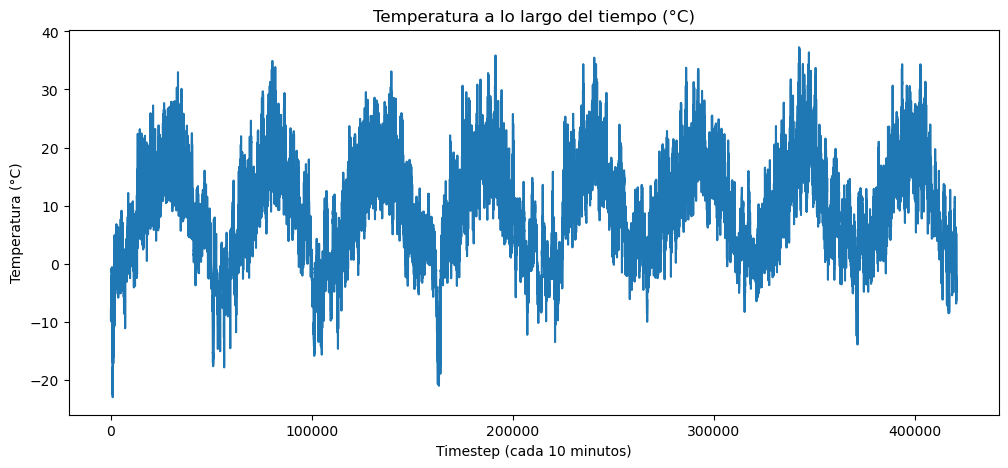

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

df = pd.read_csv("jena_climate_2009_2016.csv")

print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())


temps = df["T (degC)"].values.astype(np.float32)

plt.figure(figsize=(12, 5))
plt.plot(range(len(temps)), temps)
plt.title("Temperatura a lo largo del tiempo (°C)")
plt.xlabel("Timestep (cada 10 minutos)")
plt.ylabel("Temperatura (°C)")
plt.show()


Convertí  la columna "T (degC)"a un arreglo de float32 y luego hice una gráfica de la temperatura a lo largo del tiempo donde el eje X grafica los timesteps (cada registro cada 10 minutos) y en el eje Y se grafica la temperatura y esto sirve para darnos cuenta que si se observa que sigue patrones que nuestro modelo puede aprender para predecir la temperatura

### Limpieza y manipulación de datos

In [2]:
mean = temps.mean()
std = temps.std()
temps = (temps - mean) / std

normalicé cada valor de temperatura restándole la media y dividiéndolo entre la desviación estándar para que la nueva serie tuviera media cero y desviación estándar uno.
Como vimos en clase esto es importante porque ayuda a evitar que las magnitudes originales afecten el aprendizaje del modelo

In [2]:
def generate_timeseries(data, window_size, delay, step=1):
    x, y = [], []
    for i in range(0, len(data) - window_size - delay, step):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size + delay - 1])
    x = np.array(x)
    y = np.array(y)
    return x[..., np.newaxis], y

window_size = 120  
delay = 12         
step = 1

x, y = generate_timeseries(temps, window_size, delay, step)
x = x[:50000]
y = y[:50000]

La función generate_timeseries sirve para  las ventanas de entrada y sys etiquetas de predicción.
Se toman los datos y crea secuencias de tamaño 120 (cada registro es cada 10 minutos) que sirven como entrada (x), mientras que como salida (y) asigna el valor de temperatura que ocurre 12 pasos después (2 horas en el futuro)

Seleccioné las primeras 50,000 filas del dataset porque tardaba mucho en entrenar el modelo

### Creación del modelo

In [3]:

num_samples = len(x)

num_train_samples = int(0.5 * num_samples)
num_val_samples = int(0.25 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples

x_train, y_train = x[:num_train_samples], y[:num_train_samples]
x_val, y_val = x[num_train_samples:num_train_samples+num_val_samples], y[num_train_samples:num_train_samples+num_val_samples]
x_test, y_test = x[num_train_samples+num_val_samples:], y[num_train_samples+num_val_samples:]

print(f"Train samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

Train samples: 25000
Validation samples: 12500
Test samples: 12500


Vamos que los primeros 25,000 ejemplos se usaron para el entrenamiento, los siguientes 12,500 para la validación, y los últimos 12,500 para el conjunto de prueba.
Esto ayuda a que el modelo sea evaluado en datos más recientes simulando la predicción de eventos futuros a partir de datos pasados

In [4]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

y esta es la parte más importante del codigo, transformer_encoder toma una entrada y primero aplica una capa MultiHeadAttention para capturar las relaciones entre diferentes posiciones de la secuencia.
Luego se aplica LayerNormalization y una conexión residual para estabilizar el entrenamiento.
Luego el resultado pasa por una pequeña red  construida con dos capas Conv1D, la primera con activación ReLU para no linealidad y la segunda para ajustar la dimensión de salida.
Y ya al final se vuelve a aplicar normalización y se agrega otra conexión residual
Este diseño usado de la página que nos compartió permite que el encoder capture patrones en la serie mientras mantiene la estabilidad durante el entrenamiento.


In [5]:
def build_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(4):
        x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.25)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1)(x) 
    return keras.Model(inputs, outputs)

model = build_model(x_train.shape[1:])

build_model sirve para contruisr la arquitectura del modelo.
Primero se añadió una capa de entrada con la forma de las ventanas.
Luego se agregó cuatro bloques transformer_encoder para que el modelo aprenda relaciones complejas dentro de las secuencias de temperatura.

Después de los bloques Transformer se aññadió una capa GlobalAveragePooling1D para reducir la salida a un vector fijo, y ya desués se puso una capa densa con 128 unidades y activación ReLU.
También se agregó una capa de Dropout para prevenir sobreajuste.
Y la última capa con una sola neurona (sin activación)  ya que el objetivo es realizar una predicción continua,


In [ ]:

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=20,         
    batch_size=1024,
    callbacks=callbacks,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 1)    │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 120, 1)    │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 120, 4)    │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 4)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 120, 1)    │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 1)    │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 120, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 120, 4)    │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 120, 4)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 1)    │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,129 (113.79 KB)

 Trainable params: 29,129 (113.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 911s 37s/step - loss: 102.8916 - mae: 8.1119 - val_loss: 321.2226 - val_mae: 17.2887
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 923s 37s/step - loss: 98.7461 - mae: 7.9275 - val_loss: 301.0863 - val_mae: 16.7070
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 916s 37s/step - loss: 91.6207 - mae: 7.6264 - val_loss: 281.9146 - val_mae: 16.1334
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1016s 41s/step - loss: 87.6630 - mae: 7.4345 - val_loss: 263.6703 - val_mae: 15.5678
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 901s 36s/step - loss: 81.9082 - mae: 7.1561 - val_loss: 246.2764 - val_mae: 15.0084
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 727s 29s/step - loss: 76.5427 - mae: 6.9288 - val_loss: 229.6787 - val_mae: 14.4541
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 755s 30s/step - loss: 71.4360 - mae: 6.6506 - val_loss: 213.8447 - val_mae: 13.9045
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 766s 31s/step - loss: 66.8788 - mae: 6.4065 - val_loss: 198.7346 - val_mae: 13.3586
Epoch 9/20
25/25 ━━━━━

Luego hicimos la compilación utilizando la función compile.
Se utilizó como función de pérdida el mse porque es continua la temperatura, y el mae que facilita interpretar el desempeño del modelo en unidades cercanas a la variable original.

Se utiliza el optimizador Adam con una tasa de aprendizaje pequeña para favorecer una convergencia más estable.
Para evitar sobreajuste se usa un callback de EarlyStopping que detendría el entrenamiento si la métrica de validación no mejoraba durante 5 épocas consecutivas.
Puse un máximo de 20 épocas y con un batch_size de 1024 para que fuera rápido la ejecuación porque ya se había tardado mucho y no terminaba, lo dejé como 4 horas y estaba en la segunda época apenas, por eso reduje el dataet y las epocas y modifiqu+e el batch_size

In [7]:
print("Evaluación en conjunto de validación:")
model.evaluate(x_val, y_val)

print("Evaluación en conjunto de prueba:")
model.evaluate(x_test, y_test)



Evaluación en conjunto de validación:
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - loss: 74.2048 - mae: 7.6801
Evaluación en conjunto de prueba:
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - loss: 32.4290 - mae: 4.4973


[18.448490142822266, 3.3626163005828857]

En el conjunto de validación, el modelo obtuvo un error cuadrático medio (loss) de aproximadamente 74.20 y un error absoluto medio (mae) de 7.68, mientras que en el conjunto de prueba obtuvo un loss de 32.43 y un mae de 4.50.

Estos resultados nos dicen que el modelo presenta un margen de error considerable, que yo atribuyo a que fueron pocos datos los utilizados, pero profe mi computadora tardó 4.45 horas para ejecutarlo así con estos datos